# XGBoost on 5JUN2023 data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import shap

## load data

In [4]:
df = pd.read_csv("../data/5JUN2023_Provisional_endo_study_data_to_test_AI.csv").fillna(0)
df.Sex = np.where(df.Sex == "male", 0, 1)
# df.Sex = df.Sex.astype('category')
df.head()

,Sex,A_EPM_distance,A_EPM_pct_open_arms,A_Open_field_distance,A_LOF_pct_center,RP_Withdrawal_latency,OR_lick_time,OR_num_lick_bursts,OR__Lick_burst_length,FSA_Consumption_time,DSA_1st_week_infusions,OPAD_37oC__lick_face,OPAD_46_5oC_lick_face,RP_Delta_hargreaves
0,0,1272.67,31.58,5128.37,12.46,14.48,97.350,69.25,1.372342,66.45,86.0,10.25,1.50,0.06
1,0,1272.52,18.75,5037.27,10.68,14.84,85.125,105.00,1.444197,75.28,87.0,24.75,5.50,0.17
2,0,1462.30,29.03,5340.03,19.06,11.68,205.375,112.75,1.459464,64.88,120.0,15.00,5.00,-1.38
3,0,1288.02,20.59,5384.21,5.36,12.69,185.550,71.75,1.312209,29.45,94.0,15.75,4.25,-0.41
4,0,880.52,4.35,3919.19,1.65,17.56,239.200,136.75,1.912567,61.02,108.0,18.75,5.00,2.49


## standardize data

In [5]:
# determine which cols to standardize
z_cols = [
    "A_EPM_distance", 
    "A_EPM_pct_open_arms", 
    "A_Open_field_distance", 
    "A_LOF_pct_center", 
    "RP_Withdrawal_latency", 
    "OR_lick_time", 
    "OR_num_lick_bursts", 
    "OR__Lick_burst_length", 
    "FSA_Consumption_time", 
    "DSA_1st_week_infusions", 
    "OPAD_37oC__lick_face", 
    "OPAD_46_5oC_lick_face", 
    "RP_Delta_hargreaves"
]

# standarize df values
scaler = StandardScaler() # creates z-scores
scaled_data = scaler.fit_transform(df[z_cols].to_numpy())

# put scaled data in dataframe, and add sex data
scaled_df = pd.DataFrame(scaled_data, columns=z_cols)
scaled_df = pd.concat([df[['Sex']], scaled_df], axis=1)
scaled_df.head()

,Sex,A_EPM_distance,A_EPM_pct_open_arms,A_Open_field_distance,A_LOF_pct_center,RP_Withdrawal_latency,OR_lick_time,OR_num_lick_bursts,OR__Lick_burst_length,FSA_Consumption_time,DSA_1st_week_infusions,OPAD_37oC__lick_face,OPAD_46_5oC_lick_face,RP_Delta_hargreaves
0,0,-0.018964,0.733076,-0.131135,1.036909,0.201703,-1.263194,-0.717777,-0.528817,0.536718,-0.034145,-0.925942,-2.686533,-0.328085
1,0,-0.019549,-0.266963,-0.236146,0.667732,0.412481,-1.548823,0.864985,-0.081422,1.027931,-0.016174,1.571948,0.561995,-0.196131
2,0,0.720971,0.534316,0.112846,2.405766,-1.437681,1.260741,1.208102,0.013638,0.449379,0.576878,-0.107668,0.155929,-2.055477
3,0,0.040932,-0.123543,0.163772,-0.435649,-0.846332,0.797542,-0.607095,-0.903226,-1.521592,0.109625,0.021534,-0.453170,-0.891886
4,0,-1.549130,-1.389376,-1.524957,-1.205112,2.005024,2.051040,2.270655,2.834815,0.234647,0.361223,0.538338,0.155929,2.586891


## build train/test datasets
note: `X` is `scaled_df` with the target (`DSA_1st_week_infusions`) dropped. `y` is the target we want to predict.

In [6]:
X, y = scaled_df.drop('DSA_1st_week_infusions', axis=1), scaled_df.DSA_1st_week_infusions

In [7]:
# create test and train datasets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X,
        y,
        test_size=0.2, 
        random_state=42
    )

## train xgboost regessor model

In [8]:
print(xgb.__version__)

1.7.5


### find best parameters for model using grid search
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [9]:
# used to find scorer names
# import sklearn
# sklearn.metrics.get_scorer_names() 

In [10]:
cv_params = {
    'n_estimators': range(1,200),              # default = 100
    'max_depth': range(1, 10),                 # default = 3
    'learning_rate': [.1, .3, .4, .5, .6],     # default = .3
    'colsample_bytree': [.6, .7, .8, .9, 1],   # default = 1,
    'booster':['gbtree']
}

In [11]:
grid_search = GridSearchCV(xgb.XGBRegressor(), cv_params, n_jobs=5, scoring='neg_mean_absolute_error', refit=True)

In [12]:
# grid_search.fit(X, y)
# grid_search.best_params_

# This takes a while to run, but the results were:
# {
#     'booster': 'gbtree',
#     'colsample_bytree': 1,
#     'learning_rate': 0.4,
#     'max_depth': 3,
#     'n_estimators': 7
# }

### test different parameters on model
Compute models and variable importantances for:
* model with no params (i.e., default model)
* best params found by grid search
* increase depth and estimators to **10**
* increase depth and estimators to **15**
* increase depth and estimators to **25**
* 

Through trial and error, I found that the top 3 variables do not change after using settings of **25** estimators and tree depth. These top 3 variables are:
* `OPAD_46_5oC_lick_face`
* `FSA_Consumption_time`
* `A_EPM_distance`

Note: `Sex` was in the top 4 in all models.

### compute baseline model
calculate the variable importance using default settings

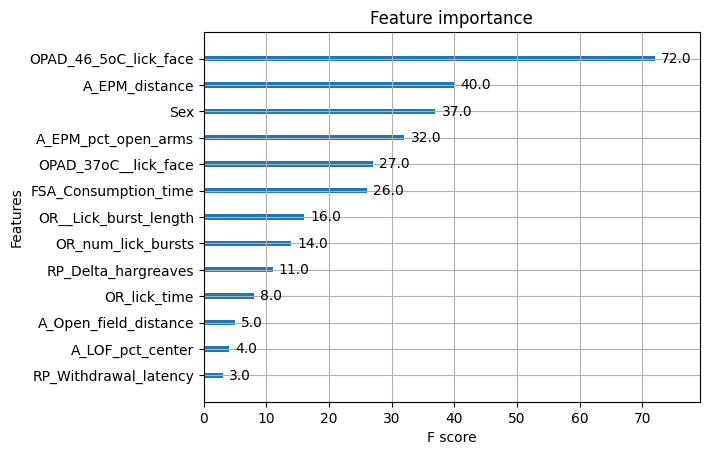

<Figure size 1200x800 with 0 Axes>

In [13]:
# create an xgboost regression model
model = xgb.XGBRegressor()
model.fit(X,y)
xgb.plot_importance(model)
plt.figure(figsize = (12, 8))
plt.show()

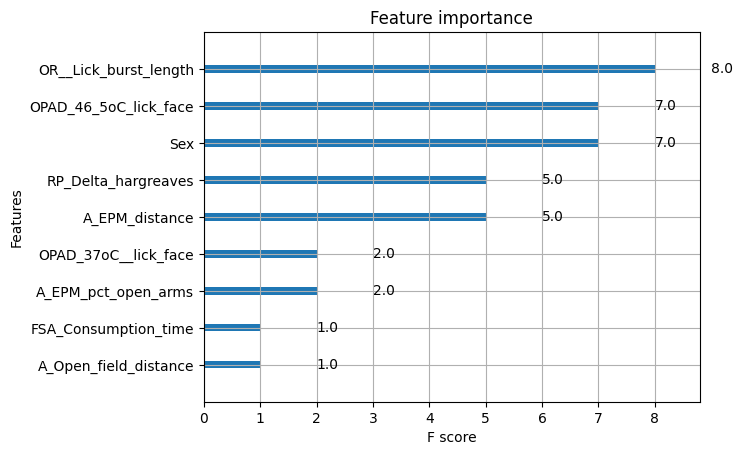

<Figure size 1200x800 with 0 Axes>

In [14]:
# test best params
params = \
    {
        'booster': 'gbtree',
        'colsample_bytree': 1,
        'learning_rate': 0.4,
        'max_depth': 3,
        'n_estimators': 7
    }
model = xgb.XGBRegressor(**params)
model.fit(X, y)
xgb.plot_importance(model)
plt.figure(figsize = (12, 8))
plt.show()

increase depth the trees and estimators to **10**

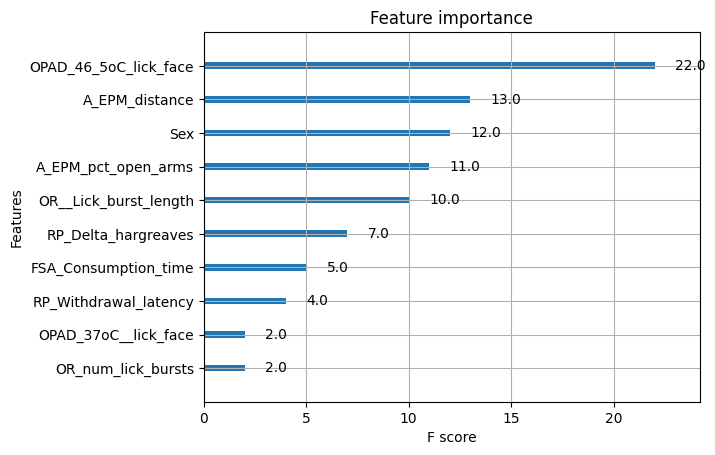

<Figure size 1200x800 with 0 Axes>

In [15]:
# test best params
params = \
    {
        'booster': 'gbtree',
        'colsample_bytree': 1,
        'learning_rate': 0.4,
        'max_depth': 10,
        'n_estimators': 10
    }
model = xgb.XGBRegressor(**params)
model.fit(X, y)
xgb.plot_importance(model)
plt.figure(figsize = (12, 8))
plt.show()

increase depth the trees and estimators to **15**

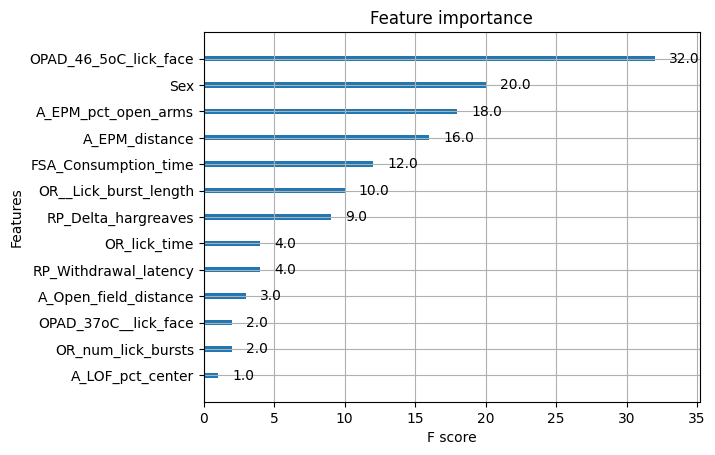

<Figure size 1200x800 with 0 Axes>

In [16]:
# test best params
params = \
    {
        'booster': 'gbtree',
        'colsample_bytree': 1,
        'learning_rate': 0.4,
        'max_depth': 15,
        'n_estimators': 15
    }
model = xgb.XGBRegressor(**params)
model.fit(X, y)
xgb.plot_importance(model)
plt.figure(figsize = (12, 8))
plt.show()

increase depth the trees and estimators to **25**

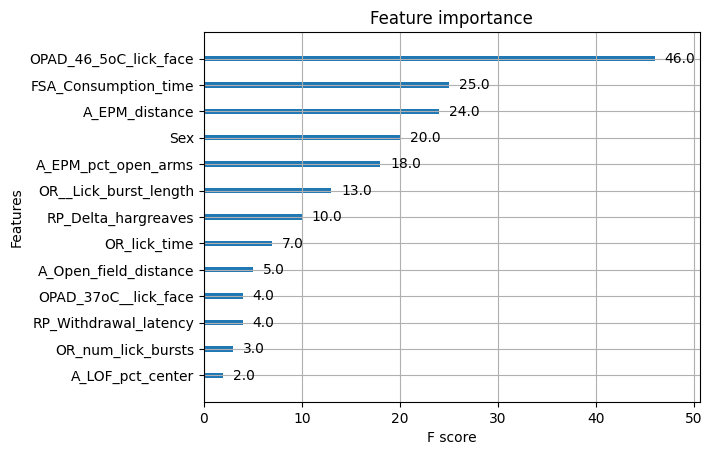

<Figure size 1200x800 with 0 Axes>

In [17]:
# test best params
params = \
    {
        'booster': 'gbtree',
        'colsample_bytree': 1,
        'learning_rate': 0.4,
        'max_depth': 25,
        'n_estimators': 25
    }
model = xgb.XGBRegressor(**params)
model.fit(X, y)
xgb.plot_importance(model)
plt.figure(figsize = (12, 8))
plt.show()

## SHAP values

Using the last model from above (i.e., max_depth=25, n_estimators=25) explore the SHAP values.

references:
* https://github.com/slundberg/shap  
* https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a
* https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454
* https://richardjli.github.io/shap
* https://christophm.github.io/interpretable-ml-book/shap.html

In [18]:
X.columns.tolist()

['Sex',
 'A_EPM_distance',
 'A_EPM_pct_open_arms',
 'A_Open_field_distance',
 'A_LOF_pct_center',
 'RP_Withdrawal_latency',
 'OR_lick_time',
 'OR_num_lick_bursts',
 'OR__Lick_burst_length',
 'FSA_Consumption_time',
 'OPAD_37oC__lick_face',
 'OPAD_46_5oC_lick_face',
 'RP_Delta_hargreaves']

In [19]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

explainer = shap.TreeExplainer(model, X, feature_names=X.columns.tolist())
shap_values = explainer(X)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X)

In [20]:
# shap.plots.waterfall(shap_values[0])
# shap_interaction_values

### explore variable importance

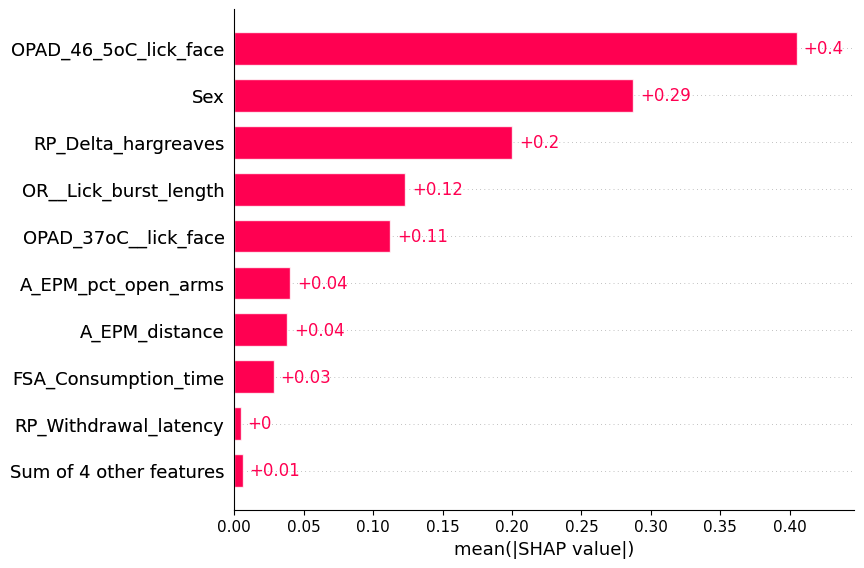

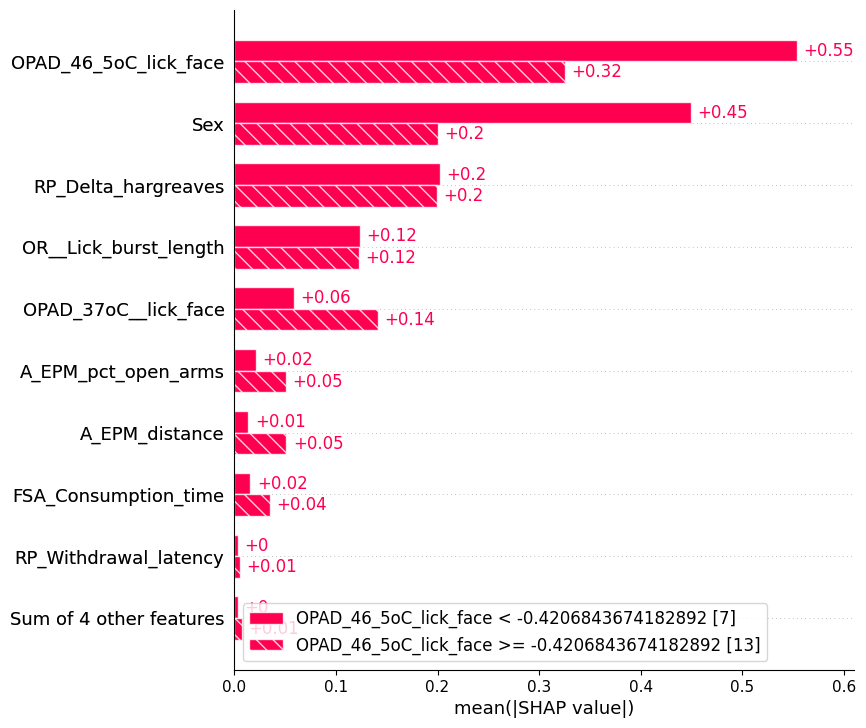

In [21]:
shap.plots.bar(shap_values)
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

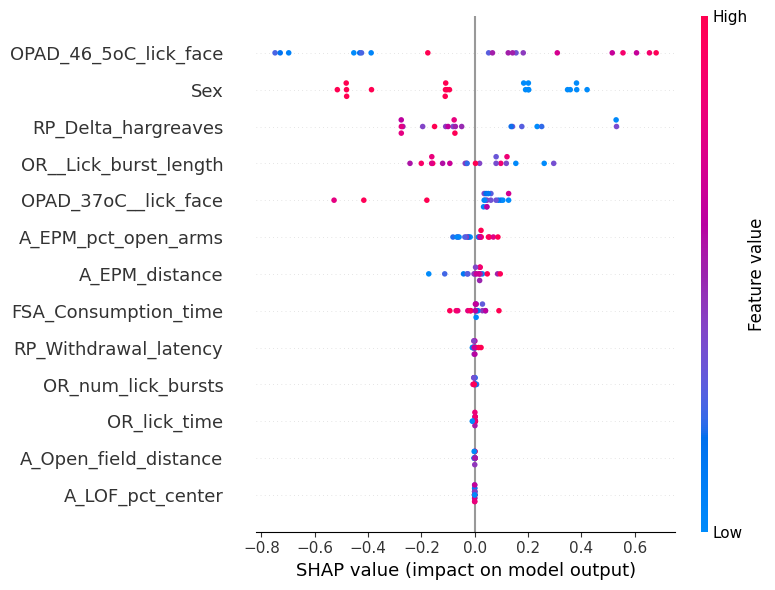

In [22]:
shap.summary_plot(shap_values, X, plot_size=(8, 6))

In [23]:
X.columns.to_list()

['Sex',
 'A_EPM_distance',
 'A_EPM_pct_open_arms',
 'A_Open_field_distance',
 'A_LOF_pct_center',
 'RP_Withdrawal_latency',
 'OR_lick_time',
 'OR_num_lick_bursts',
 'OR__Lick_burst_length',
 'FSA_Consumption_time',
 'OPAD_37oC__lick_face',
 'OPAD_46_5oC_lick_face',
 'RP_Delta_hargreaves']

### interaction values
Using `shap_interaction_values` explore variable interactions.

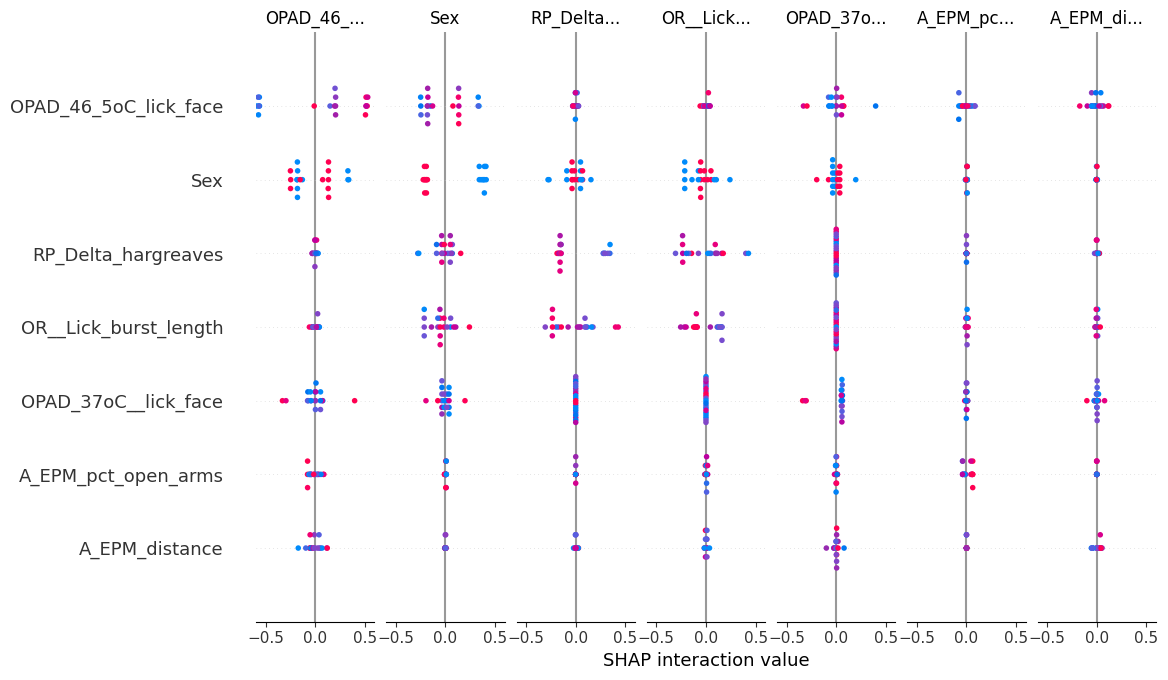

In [24]:
shap.summary_plot(shap_interaction_values, X)

The above is hard to read. Let's look at individual variables.

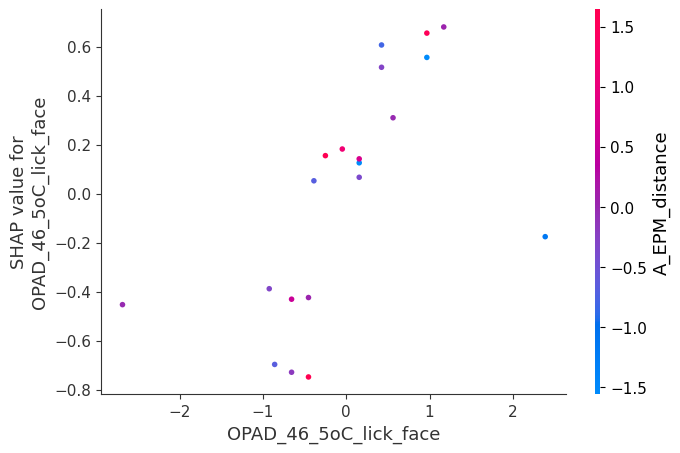

In [25]:
shap.dependence_plot("OPAD_46_5oC_lick_face", shap_values.values, X)

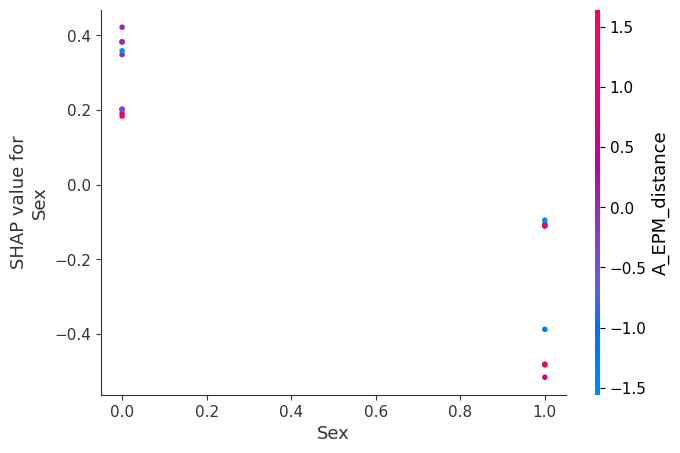

In [26]:
shap.dependence_plot("Sex", shap_values.values, X)

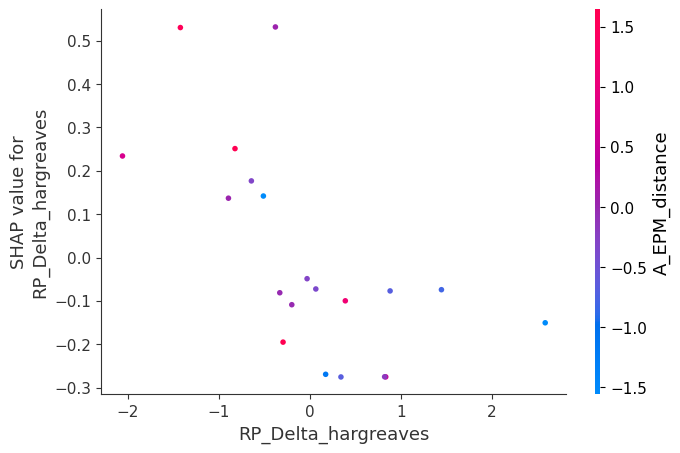

In [27]:
shap.dependence_plot("RP_Delta_hargreaves", shap_values.values, X)

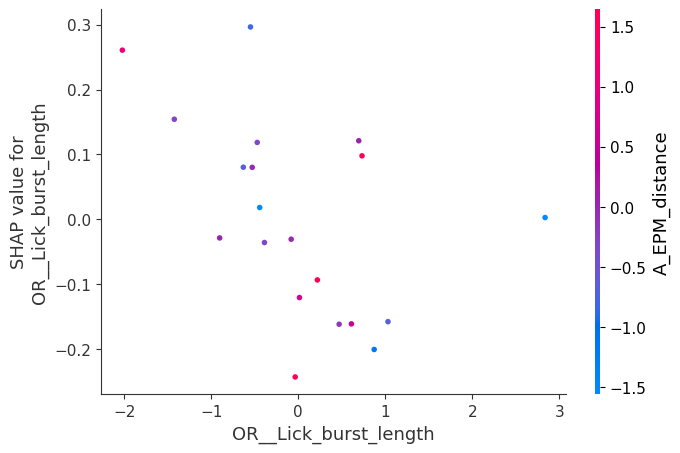

In [28]:
shap.dependence_plot("OR__Lick_burst_length", shap_values.values, X)

A_EPM_distance is related to A_EPM_pct_open_arms ...

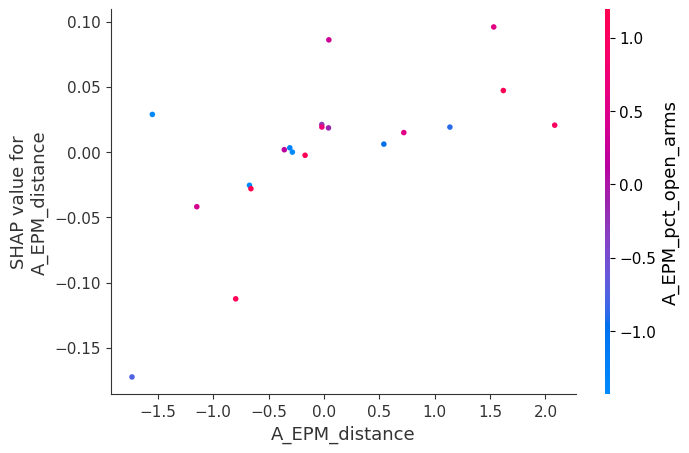

In [29]:
shap.dependence_plot("A_EPM_distance", shap_values.values, X)

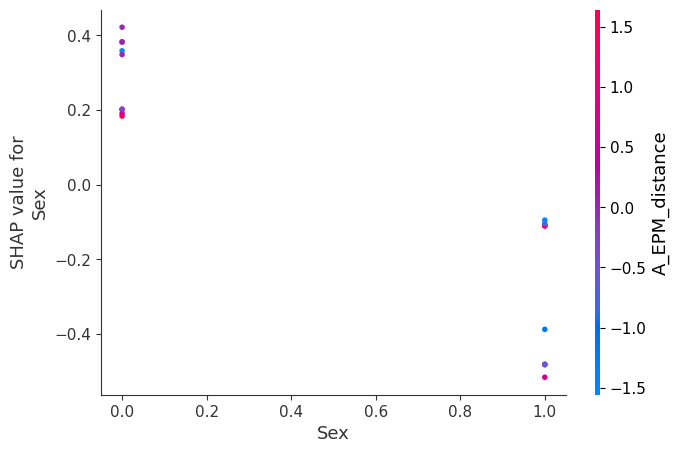

In [30]:
shap.dependence_plot("Sex", shap_values.values, X)